# Creating a basic Cluster Expansion

In [2]:
import numpy as np
import json
from monty.serialization import loadfn
from smol.cofe import ClusterSubspace, StructureWrangler, ClusterExpansion
from smol.cofe.space import Cluster
from smol.cofe.extern import EwaldTerm

import matplotlib.pyplot as plt
import matplotlib

In [3]:
prim = loadfn('data/LMTOF.mson')
prim

Structure Summary
Lattice
    abc : 2.9698484799999996 2.9698484799999996 2.9698484799999996
 angles : 60.00000000000001 60.00000000000001 60.00000000000001
 volume : 18.521999981598675
      A : -2.571964229070601 0.0 -1.4849242400000002
      B : -2.571964229070601 0.0 1.4849242399999998
      C : -1.7146428193804006 2.424871129793404 0.0
PeriodicSite: Li+:0.333, Ti4+:0.333, Mn3+:0.333 (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: O2-:0.500, F-:0.500 (-3.4293, 1.2124, -0.0000) [0.5000, 0.5000, 0.5000]

In [4]:
subspace = ClusterSubspace.from_cutoffs(prim,
                                      cutoffs={2: 7.1, 3: 4, 4:4}, # will include orbits of 2 and 3 sites.
                                      basis='sinusoid',
                                      supercell_size='volume')

# supercell_size specifies the method to determine the supercell size
# when trying to match a structure.
# (See pymatgen.structure_mathcer.StructureMatcher for more info)

subspace.add_external_term(EwaldTerm(eta=None))
# print(subspace) # single site and empty orbits are always included.

In [5]:
A_valid = np.load('data/A_valid_7_4_4_MnTiOF_fromBin_sinusoid', allow_pickle=True)
f_valid = np.load('data/f_valid_7_4_4_MnTiOF_fromBin_sinusoid', allow_pickle=True)

## Optimization started here

In [6]:
from theorytoolkit.regression.gurobi_optimization import l0l1_diretct_optimize, l0l2_hierarchy_optimize_quicksum

In [7]:
correlated_ID = subspace.function_hierarchy(min_size=2, invert=True)
print(correlated_ID)

[[], [], [], [], [50, 47, 46, 39, 37, 36], [51, 49, 48, 40, 38, 37], [46, 42, 41, 36], [48, 47, 43, 42, 37], [49, 44, 43, 38], [51, 50, 45, 40, 39], [50, 48, 46], [51, 49, 47], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [72, 71, 67, 58, 53, 52], [74, 73, 69, 68, 59, 54, 53], [76, 75, 70, 60, 55, 54], [77, 69, 67, 59, 58, 56], [78, 70, 68, 60, 59, 57], [71, 62, 61, 52], [73, 72, 63, 62, 53], [75, 74, 64, 63, 54], [76, 65, 64, 55], [78, 77, 66, 57, 56], [79, 73, 71, 67], [80, 74, 72, 69], [80, 75, 73, 68], [81, 76, 74, 70], [80, 79, 77, 68, 67], [81, 80, 78, 70, 69], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [8]:
mu0, mu1, mu2 = 1e-4, 1e-4, 1e-4
ecis_gurobi_L0L1 = l0l1_diretct_optimize(A=A_valid, f=f_valid, mu0=mu0, mu1=mu1)

Academic license - for non-commercial use only - expires 2021-12-06
Using license file /home/lbluque/gurobi.lic
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter PSDTol to 1e-05
   Prev: 1e-06  Min: 0.0  Max: inf  Default: 1e-06


In [9]:
ecis_gurobi_L0L2_noHierarchy, _ = l0l2_hierarchy_optimize_quicksum(A= A_valid, f=f_valid, mu0=mu0, mu2=mu2,
                                                                 correlateID= None)

ecis_gurobi_L0L2_withHierarchy, _ = l0l2_hierarchy_optimize_quicksum(A= A_valid, f=f_valid, mu0=mu0, mu2=mu2,
                                                                 correlateID= correlated_ID)

Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Parameter PSDTol unchanged
   Value: 1e-06  Min: 0.0  Max: inf  Default: 1e-06
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Parameter PSDTol unchanged
   Value: 1e-06  Min: 0.0  Max: inf  Default: 1e-06


In [10]:
from theorytoolkit.regression import L1L0, L2L0

In [11]:
f = 1 / (2 * A_valid.shape[0])
alpha = 2 * f * mu0 # this is the scale conversion bw gurobi direct and cvxpy classes
# If using different values of mu0, mu1 and mu2 you will need to play with l0_ratio as well

# if gurobi is installed cvxpy classes below will use it as solver.
# otherwise will default to ECOS_BB probably...
L1L0_opt = L1L0(alpha=alpha, l0_ratio=0.5)
L1L0_opt.fit(X=A_valid, y= f_valid)
ecis_CVX_L0L1 = L1L0_opt.coef_ 

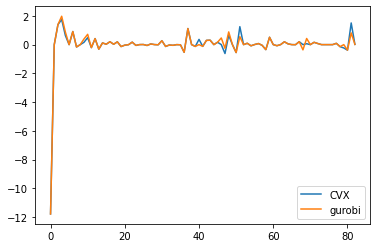

Non-Zero element in CVX method:  67
Non-Zero element in gurobi method:  67


In [12]:
plt.plot(ecis_CVX_L0L1, label ='CVX')
plt.plot(ecis_gurobi_L0L1, label ='gurobi')
plt.legend()
plt.show()

print("Non-Zero element in CVX method: ", np.sum(np.abs(ecis_CVX_L0L1) > 1e-6))
print("Non-Zero element in gurobi method: ", np.sum(np.abs(ecis_gurobi_L0L1) > 1e-6))

In [13]:
L2L0_opt = L2L0(alpha=alpha, l0_ratio=0.5)
L2L0_opt.fit(X=A_valid, y=f_valid)
ecis_CVX_L0L2 = L2L0_opt.coef_ 

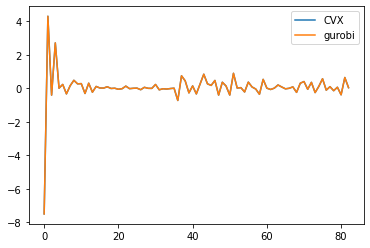

Non-Zero element in CVX method:  83
Non-Zero element in gurobi method:  83


In [14]:
plt.plot(ecis_CVX_L0L2, label ='CVX')
plt.plot(ecis_gurobi_L0L2_noHierarchy, label = 'gurobi')
plt.legend()
plt.show()

print("Non-Zero element in CVX method: ", np.sum(np.abs(ecis_CVX_L0L2) > 1e-6))
print("Non-Zero element in gurobi method: ", np.sum(np.abs(ecis_gurobi_L0L2_noHierarchy) > 1e-6))

# Old Summary

* From the current test results, gurobi and CVX do not show the same solution.
* This inconsistency does not mean either CVX or gurobi is wrong.
* The result indicates one should be careful with the definition in the funciton, even though they are the same in principle

# New Summary

* From the current test results, gurobi and CVX show almost the same solutions, if care is take in setting the equivalent hyperparameters
* cvxpy solvers are written so that hyperparameters are not problem size dependent, So they will differ from the ones
  used in gurobi by a factor of 2 times the number of data points
* There are some differences in the obtained solutions particularly at hyperparameter values where the l0 norm starts to zero out some coefficients but the solutions are both valid
* This inconsistency does not mean either cvx or gurobi is wrong.